In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import cv2

from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import cross_validation as cv
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model

In [2]:
train = pd.read_csv('../data/raw/train.csv')

print train.shape

(29118021, 6)


In [3]:
uniq = train['place_id'].nunique()
print uniq

108390


* The number of unique values is huge. This makes me think in a direction where we could center basis functions at the centers of discovered clusters. Discover cluster centers via K-Means?

In [4]:
train_X = train.values[:,:-1]
train_t = train.values[:,-1]

print train_X.shape
print train_t.shape

(29118021L, 5L)
(29118021L,)


In [5]:
train.describe()

,row_id,x,y,accuracy,time,place_id
count,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07
mean,1.455901e+07,4.999770e+00,5.001814e+00,8.284912e+01,4.170104e+05,5.493787e+09
std,8.405649e+06,2.857601e+00,2.887505e+00,1.147518e+02,2.311761e+05,2.611088e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000016e+09
25%,7.279505e+06,2.534700e+00,2.496700e+00,2.700000e+01,2.030570e+05,3.222911e+09
50%,1.455901e+07,5.009100e+00,4.988300e+00,6.200000e+01,4.339220e+05,5.518573e+09
75%,2.183852e+07,7.461400e+00,7.510300e+00,7.500000e+01,6.204910e+05,7.764307e+09
max,2.911802e+07,1.000000e+01,1.000000e+01,1.033000e+03,7.862390e+05,9.999932e+09


In [6]:
train.head()

,row_id,x,y,accuracy,time,place_id
0,0,0.7941,9.0809,54,470702,8523065625
1,1,5.9567,4.7968,13,186555,1757726713
2,2,8.3078,7.0407,74,322648,1137537235
3,3,7.3665,2.5165,65,704587,6567393236
4,4,4.0961,1.1307,31,472130,7440663949


In [7]:
train.tail()

,row_id,x,y,accuracy,time,place_id
29118016,29118016,6.5133,1.1435,67,399740,8671361106
29118017,29118017,5.9186,4.4134,67,125480,9077887898
29118018,29118018,2.9993,6.3680,67,737758,2838334300
29118019,29118019,4.0637,8.0061,70,764975,1007355847
29118020,29118020,7.4523,2.0871,17,102842,7028698129


* Null Hypothesis: the plotted joints are identical

In [ ]:
# train['place_id'].value_counts().plot(kind='bar')

# train['place_id'].value_counts().plot(kind='barh')

In [ ]:
sb.distplot(train['accuracy'], bins=50, kde=False, rug=True);

In [ ]:
sb.distplot(train['accuracy'], hist=False, rug=True);

In [ ]:
with sb.axes_style("white"):
    sb.jointplot(x=train['x'], y=train['y'], kind="hex", color="k");

* We have p = 0.068, hence the null hypothesis does not hold

In [ ]:
with sb.axes_style("white"):
    sb.jointplot(x=train['accuracy'], y=train['time'], kind="hex", color="k");

* We have p = 0, hence the null hypothesis does not hold
* We can also observe that as time passes, we mostly observe that accuracy falls in 3 distinct ranges

# 1. Analysis

## Notes

### Essential questions

* Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?
    * We are trying to order the places (i.e by their likelihood) based on the following measurements from the dataset: coordinates, accuracy (?), time (?) and place_id.

* Did you define the metric for success before beginning?
    * The metric is Mean Average Precision (What is this?)

* Did you understand the context for the question and the scientific or business application?
    *We are building a system that would rank a list of places given 'coords', 'accuracy' and 'time'. The purpose might be to enable for specific ads (i.e interesting places around the hotel) to be shown to the person (on FB?) depending on this list.

* Did you record the experimental design?
    * Given.

* Did you consider whether the question could be answered with the available data?
    * We need to further explore 'accuracy' and to check if we could identify different clusters of users - we don't know if the data was genereted by 1 person or many, so we need to check its structure.

### Checking the data

* Null values?
    * No!

* What do we know of the measurements?
    * First column is ID and is useless.

    * Second and Third are coords., they are in kilometers and are floating point. Min is (0,0) and max is (10,10);

    * Fourth column is accuracy. Range is (1, 1033) and seems to follow a power law distribution. We assume that this is the accuracy of the location given by the GPS. This claim is supported by the fact that the data comes from a mobile device, which is able to give location but this information is sometimes not accurate (i.e in buildings), so we would like to know what is the accuracy of the reading. In order to convert this into real accuracy, we need to normalize the column and assign it values of (1 - current_val).

    * The fifth column is time given as a timestamp. What patterns are there?

    * Last column is the class_id, given as an integer

# 2. Pre-processing

In [8]:
col_headers = list(train.columns.values)
print col_headers
train[col_headers[1:-1]] = train[col_headers[1:-1]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
train['accuracy'] = 1 - train['accuracy']

['row_id', 'x', 'y', 'accuracy', 'time', 'place_id']


In [9]:
train.describe()

,row_id,x,y,accuracy,time,place_id
count,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07
mean,1.455901e+07,4.999770e-01,5.001814e-01,9.206888e-01,5.303857e-01,5.493787e+09
std,8.405649e+06,2.857601e-01,2.887505e-01,1.111936e-01,2.940282e-01,2.611088e+09
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000016e+09
25%,7.279505e+06,2.534700e-01,2.496700e-01,9.282946e-01,2.582628e-01,3.222911e+09
50%,1.455901e+07,5.009100e-01,4.988300e-01,9.408915e-01,5.518952e-01,5.518573e+09
75%,2.183852e+07,7.461400e-01,7.510300e-01,9.748062e-01,7.891885e-01,7.764307e+09
max,2.911802e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999932e+09


In [10]:
train.head()

,row_id,x,y,accuracy,time,place_id
0,0,0.07941,0.90809,0.948643,0.598675,8523065625
1,1,0.59567,0.47968,0.988372,0.237274,1757726713
2,2,0.83078,0.70407,0.929264,0.410368,1137537235
3,3,0.73665,0.25165,0.937984,0.896148,6567393236
4,4,0.40961,0.11307,0.970930,0.600491,7440663949


In [11]:
train.tail()

,row_id,x,y,accuracy,time,place_id
29118016,29118016,0.65133,0.11435,0.936047,0.508420,8671361106
29118017,29118017,0.59186,0.44134,0.936047,0.159594,9077887898
29118018,29118018,0.29993,0.63680,0.936047,0.938338,2838334300
29118019,29118019,0.40637,0.80061,0.933140,0.972955,1007355847
29118020,29118020,0.74523,0.20871,0.984496,0.130801,7028698129


In [12]:
train_X_norm = train.values[:,:-1]
print train_X_norm.shape

(29118021L, 5L)


In [ ]:
K = uniq
clusters = range(0,K)
batch_size = 500
n_init = 10

## 2.1 K-Means clustering

In [ ]:
random_state = np.random.RandomState(0)

mbk = MiniBatchKMeans(init='k-means++', n_clusters=K, batch_size=batch_size,
                      n_init=n_init, max_no_improvement=10, verbose=True)
X_kmeans = mbk.fit(train_X_norm)
print "Done!"

* Note: dataset of 1.3 GB is ginormous! Need to use GPU-powered algorithms ;(

## 2.2 K-Means clustering (OpenCV)

### 2.2.1 Test

(50L, 2L)


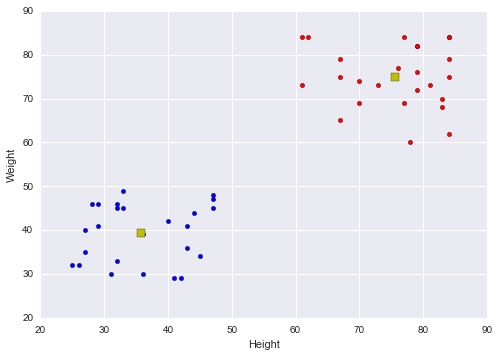

In [20]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

X = np.random.randint(25,50,(25,2))
Y = np.random.randint(60,85,(25,2))
Z = np.vstack((X,Y))

# convert to np.float32
Z = np.float32(Z)
print Z.shape

# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#ret,label,center=cv2.kmeans(Z,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
ret, label, center = cv2.kmeans(Z, 2, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Now separate the data, Note the flatten()
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]

# Plot the data
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
plt.xlabel('Height'),plt.ylabel('Weight')
plt.show()

### 2.2.1 Run Experiment

In [ ]:
train_X_norm = train_X_norm.astype(np.float32)
print train_X_norm.dtype
print train_X_norm.shape


# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv2.kmeans(train_X_norm, K, criteria, n_init, cv2.KMEANS_RANDOM_CENTERS)

print center.shape

float32
(29118021L, 5L)


* So slow, try running in cmd?